<a href="https://colab.research.google.com/github/RedBatProject/Thesis---a-two-layer-power-network/blob/main/Thesis_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# imports

In [1]:
%pip install pandapower
import pandapower as pp
import networkx as nx
import pandapower.networks as pn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandapower.topology as top
# import networkx as nx
from pandapower import plotting
from pandapower.plotting import simple_plot, pf_res_plotly,simple_plotly
import random as rn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# plt.rcParams['figure.dpi'] = 100
# plt.rcParams['savefig.dpi'] = 100

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 40.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 8.7 MB/s eta 0:00:00
  Created wheel for pandapower: filename=pandapower-2.13.1-py3-none-any.whl size=10803675 sha256=1ab08b8d9647c67404c5aa6bdbcb4e5d590e4b93ef9b1e1b91e3dbe926f74afd
  Stored in directory: /root/.cache/pip/wheels/6b/58/fb/c5c16044f0046e905e2fe55de3af6c0a43bfcc3219ed5d3af8
Successfully built pandapower


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# crate model automated

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [4]:
seed = 1537
alpha = 0.39
beta = 0.1
gamma = 1-(alpha + beta)
alpha,beta,gamma
np.random.seed(seed)


In [5]:

nodes=101
k=4
# seed=seed
# np.random.seed(seed)

p=0.2
types=0
# G = nx.watts_strogatz_graph(nodes,k,p=p,seed=seed)
# edges = list(G.edges())

In [6]:
def create_network1O1(nodes=101,k=2,seed=seed,p=0.2,types=0):
    # np.random.seed(0)
    np.random.seed(seed)
    # np.random.rand(seed)


    if types == 1:
        G1 = nx.barabasi_albert_graph(nodes,m=k,seed=seed)
    elif types == 0:
        G1 = nx.watts_strogatz_graph(nodes,k,p=p,seed=seed)
    if k > 3:
        edges = G1.edges()
        # print('edges' , len(edges))
        m = np.array(edges)
        h = len(m[m[:,0]==0])
        # print('h',h)
        nds = G1.nodes()
        po = np.random.randint(int(h/2),len(edges),int(nodes*3.2))
        # print('po',len(po))
        eds = list(np.array(edges)[po])
        eds2 = list(np.array(edges)[0:int(h/2)])
        eds = eds + eds2
        eds = np.array(eds)
        # print('eds',len(eds))
        G=nx.empty_graph()
        G.add_nodes_from(nds)
        G.add_edges_from(np.array(eds))
        # print(len(G.edges()))
    else:
        G = G1
        # edges= G.edges()

    components_of_groph = sorted(nx.connected_components(G), key=len, reverse=True)
    while len(components_of_groph) != 1:
        multiple = len(components_of_groph)
        # print(f'model has {multiple} clusters so we connected them.')
        # drows2(G)
        # if len(components_of_groph)==2:
        g1 = list(components_of_groph[0])
        g2 = list(components_of_groph[1])
        if len(g2) < 3:
            k1 = 1
        else:
            k1 = k
        grand1 = np.random.randint(0,len(g1),k1)
        grand2 = np.random.randint(0,len(g2),k1)
        # print(grand1,grand2)
        for i,j in zip(grand1,grand2):
            print(g1[i],g2[j])
            G.add_edge(g1[i],g2[j])
        # else:pass
        components_of_groph = sorted(nx.connected_components(G), key=len, reverse=True)
    # drows2(G)


    Nett = pn.case118()

    #create empty net
    net = pp.create_empty_network()

    l =(nodes/Nett['bus'].shape[0]) # relation between our network on 118 network
    #create buses and bus elements
    sigma,mu  = Nett['bus']['vn_kv'].std(),Nett['bus']['vn_kv'].mean()
    # sigma,mu = sigma*l,mu*l
    sigma,mu = sigma*l,mu

    s0 = np.abs(np.random.normal(mu, sigma, nodes))

    sigma,mu  = Nett['load']['p_mw'].std(),Nett['load']['p_mw'].mean()
    # sigma,mu = sigma*l,mu*l
    sigma,mu = sigma*l,mu

    s1 = np.abs(np.random.normal(mu, sigma, nodes))

    # sigma,mu  = Nett['load']['q_mvar'].std(),Nett['load']['q_mvar'].mean()
    # sigma,mu = sigma*l,mu*l
    # sigma,mu = sigma*l,mu
    sigma,mu = 0.2,0.5
    s2 = np.abs(np.random.normal(mu, sigma, nodes))
    s2[s2>0.8] = 0.8
    # s2[s2<0.1] = 0.8

    sigma,mu  = Nett['gen']['p_mw'].std(),Nett['gen']['p_mw'].mean()
    # sigma,mu = sigma*l,mu*l
    sigma,mu = sigma*l,mu

    s3 = np.abs(np.random.normal(mu, sigma,int(30*l)))

    sigma,mu = 0.03,0.97
    s4 = np.abs(np.random.normal(mu, sigma, int(30*l)))

    for i in range(nodes):
        pp.create_bus(net, vn_kv=s0[i], name=f"Bus {i}")
        # if i not in jj:
            # pp.create_load(net, bus=i, p_mw=s1[i], q_mvar=s2[i], name=f"Load {i}")

    pp.create_ext_grid(net, bus=0, vm_pu=1.02, name="Grid Connection")

    jj = set()

    for i in range(int(30*l)):
        j = np.random.randint(nodes)
        if j not in jj and j!=0:
            pp.create_gen(net=net, bus=j, p_mw=s3[i], vm_pu=s4[i],name=f"gen {i}",max_p_mw=1.5*s3[i] ,min_p_mw=0,min_q_mvar=-20*l,max_q_mvar=20*l)
        jj.add(j)
    s4 = np.abs(np.random.normal(mu, sigma, nodes))
    for i in range(1,nodes):
        if i not in jj:
            pp.create_load(net, bus=i, p_mw=s1[i], q_mvar=s2[i]*s1[i], name=f"Load {i}",vm_pu=s4[i])

    edges = list(G.edges())
    for i,j in edges:
        # print(i,j)
        pp.create_line(net, from_bus=i, to_bus=j, length_km=1, name=f"Line {i}-{j}",std_type="NAYY 4x50 SE",)

    net['line']['max_i_ka'] = 20 * l

    pp.rundcpp(net=net)
    m = np.array(net['res_line'][net['res_line']['loading_percent']>10].index)
    # print(net['line']['max_i_ka'][m])
    # net['line']['max_i_ka'][m] *= (net['res_line']['loading_percent'][m]*1.25)/100
    net['line']['max_i_ka'][m] *= (net['res_line']['loading_percent'][m]*(10 + np.random.rand() * 15))/100
    pp.rundcpp(net=net)
    # print(net['line']['max_i_ka'][m])
    G_power = top.create_nxgraph(net=net)
    posP = nx.spring_layout(G_power, seed = seed)
    kl = pd.DataFrame().from_dict(posP,orient='index')
    net['bus_geodata']['x'] = kl[0]
    net['bus_geodata']['y'] = kl[1]
    net['bus_geodata']['coords'] = None



    return net

In [7]:
def create_net(net):
    np.random.seed(seed)

    Net = net
    G_power = top.create_nxgraph(net=Net)
    # extract some feature for future
    G_power_nodes = G_power.nodes()
    G_power_nodes_Number = len(G_power_nodes)
    G_power_edges = G_power.edges()
    target = int(Net.ext_grid['bus'])
    Static_node_of_power = len(Net.bus)
    G_scale_free = nx.scale_free_graph(n= Static_node_of_power, alpha= alpha, beta= beta, gamma= gamma, seed= seed, delta_in=1, delta_out=1 )
        # create Com from Scale free
    # print(set(G_scale_free.nodes()))
    G_com_edges = G_scale_free.edges()
    G_com_edges_set = set(G_com_edges)
    G_com_edges_set_non_redundancy = []
    # print(set(G_com.nodes()))
    for G_edge in G_com_edges_set:
        if (G_edge[1],G_edge[0]) and (G_edge[0],G_edge[1]) not in G_com_edges_set_non_redundancy:
            if G_edge[1] != G_edge[0]:
                G_com_edges_set_non_redundancy.append(G_edge)
    G_com = nx.MultiGraph()
    # print(set(G_com.nodes()))
    G_com.add_edges_from(G_com_edges_set_non_redundancy);
    if len(set(G_scale_free.nodes() - set(G_com.nodes))) > 0:
        for ij in list(set(G_scale_free.nodes() - set(G_com.nodes))):
            G_com.add_edges_from([(ij,np.random.randint(len(G_power.nodes())))])
    # print(set(G_com.nodes()))
        # add a few work to this
    mapping = {0:target,target:0}
    G_com = nx.relabel_nodes(G_com, mapping)

        # extract initial information
    G_com_nodes = G_com.nodes()
    # print(set(G_com.nodes()))
    G_com_edges = G_com.edges()
    # print("Networks settings are Done!")
    return G_com,Net,G_power,target,G_power_nodes_Number

In [8]:
def drows():
    np.random.seed(seed)

    posC = nx.spring_layout(G_com, seed = seed)
    posP = nx.spring_layout(G_power, seed = seed)
    plt.figure(figsize = (10,6))
    plt.subplot(211)
    nx.draw(G_com,pos = posC ,with_labels=True)
    plt.subplot(212)
    nx.draw(G_power, pos = posP,with_labels=True)
    plt.show()

In [9]:
def drows2(G_power):
    np.random.seed(seed)

    posP = nx.spring_layout(G_power, seed = seed)
    plt.figure(figsize = (30,20))
    # plt.subplot(211)
    nx.draw(G_power, pos = posP,with_labels=True)
    plt.show()

In [10]:
def rendom_remove():
    np.random.seed(seed)

    removable_node = int(np.random.random() * G_power_nodes_Number)
    while target == removable_node:
        removable_node = int(np.random.random() * G_power_nodes_Number)
    Choice = np.random.random()
    rm_node = removable_node
    if Choice <0.5:
        print("first choice was Com and it is {}".format(removable_node))
        G_com.remove_node(rm_node)
        pp.drop_buses(net = Net,buses = [rm_node] , drop_elements=True)
        G_power = top.create_nxgraph(net=Net)
    else:
        print("first choice was Pow and it is {}".format(removable_node))
        pp.drop_buses(net = Net,buses = [rm_node] , drop_elements=True)
        G_com.remove_node(rm_node)
        G_power = top.create_nxgraph(net=Net)
    return G_com,Net,G_power

In [11]:
def Remove_by_purpose(remove=None):
    np.random.seed(seed)

    if remove:
        pp.drop_buses(net = Net,buses = [remove] , drop_elements=True)
        G_com.remove_node(remove)
        G_power = top.create_nxgraph(net=Net)
        return G_com,Net,G_power
    else:
        None

In [12]:
def Largest_component_with_target(G,target_node):
    np.random.seed(seed)

    # check the largest components
    components_of_groph = sorted(nx.connected_components(G), key=len, reverse=True)
    for component in components_of_groph:
        if target_node in component:
            G = G.subgraph(component)
            G = nx.MultiGraph(G)
    return G

In [13]:
def Casecade_in_pow(Net,nodes):
    np.random.seed(seed)

    Net = Net
    node = nodes
    if len(node) == 0:
        # self.node = instance_nodes - nodes
        busses = []
    elif len(node) == 1:
        busses = node
    else:

        busses = list(node)
    try:
        pp.drop_buses(Net,buses=busses,drop_elements = True)
    except:pass
    pp.rundcpp(Net)
    drop_lines = pp.overloaded_lines(Net)
    while len(drop_lines) !=0:
        # print("3")
        pp.drop_lines(Net,drop_lines)
        drop_lines = pp.overloaded_lines(Net)
        # print("line 135 worked.",self.drop_lines)
    g_inst = top.create_nxgraph(Net)
    g_inst_2 = Largest_component_with_target(g_inst,target)
    set_nodes_2 = set(g_inst) - set(g_inst_2)
    pp.drop_buses(Net,set_nodes_2,drop_elements = True)
    return Net



In [14]:
def Casecade_in_com(G_com,nodes):
    np.random.seed(seed)

    G_com = G_com
    node = nodes
    if len(node)!=0:
        # nx.is_frozen(G_com)
        G_com.remove_nodes_from(node)
    return G_com

In [15]:
def net_analysis(G):
    np.random.seed(seed)

    bb = {}
    pathlengths = []
    print("source vertex {target:length, }")
    for v in G.nodes():
        spl = dict(nx.single_source_shortest_path_length(G, v))
        # print(f"{v} {spl} ")
        print(f"{v} {np.mean(list(spl.values()))} ")
        bb[v] = np.mean(list(spl.values()))

        for p in spl:
            pathlengths.append(spl[p])

    # print()
    print(f"average shortest path length {sum(pathlengths) / len(pathlengths)}")

    # histogram of path lengths
    dist = {}
    for p in pathlengths:
        if p in dist:
            dist[p] += 1
        else:
            dist[p] = 1

    # print()
    print("with lenght X we have y path")
    verts = dist.keys()
    for d in sorted(verts):
        print(f"{d} {dist[d]}")

    print(f"radius: {nx.radius(G)}")
    print(f"diameter: {nx.diameter(G)}") #maximum lenght
    print(f"eccentricity: {nx.eccentricity(G)}")
    print(f"center: {nx.center(G)}")
    print(f"periphery: {nx.periphery(G)}") # nodes with max lenght
    print(f"density: {nx.density(G)}")
    return bb

In [16]:
def net_analysis2(G):
    np.random.seed(seed)

    bb = {}
    pathlengths = []
    # print("source vertex {target:length, }")
    for v in G.nodes():
        spl = dict(nx.single_source_shortest_path_length(G, v))
        # print(f"{v} {spl} ")
        # print(f"{v} {np.mean(list(spl.values()))} ")
        bb[v] = np.mean(list(spl.values()))

        for p in spl:
            pathlengths.append(spl[p])

    return bb

In [17]:
def gen_gy(net,num1,num2,bb1,bb2,tries,ids):
    np.random.seed(seed)

    a = len(net['gen'])
    b = int(a * abs(num1))
    c = np.random.randint(0,a,(tries,b))
    for i in c[ids]:
        net.gen['p_mw'].iloc[i] *= (1+num2)
        net.gen['max_p_mw'].iloc[i] *= (1+num2)
    name = ''
    for j in c[ids][0:-1]:
        name += f'{j}({bb1[j]},{bb2[j]})-'
    j = c[ids][-1]
    name += f'{j}({bb1[j]},{bb2[j]})'
    # names = c
    return net,name


In [18]:
def gen_gy_simple(net,num1,num2,tries,ids):
    np.random.seed(seed)

    a = len(net['gen'])
    b = int(a * abs(num1))
    c = np.random.randint(0,a,(tries,b))
    # print(c)
    for i in c[ids]:
        net.gen['p_mw'].iloc[i] *= (1+num2)
        net.gen['max_p_mw'].iloc[i] *= (1+num2)
    name = ''
    for j in c[ids][0:-1]:
        name += f'{j}-'
    j = c[ids][-1]
    name += f'{j}'
    # names = c
    return net,name

In [19]:
def gen_gy(net,num1,num2,bb1,bb2,tries,ids):
    np.random.seed(seed)

    a = len(net['gen'])
    b = int(a * abs(num1))
    c = np.random.randint(0,a,(tries,b))
    for i in c[ids]:
        net.gen['p_mw'].iloc[i] *= (1+num2)
        net.gen['max_p_mw'].iloc[i] *= (1+num2)
    name = ''
    for j in c[ids][0:-1]:
        name += f'{j}({bb1[j]},{bb2[j]})-'
    j = c[ids][-1]
    name += f'{j}({bb1[j]},{bb2[j]})'
    # names = c
    return net,name


In [20]:
def gen_gy_simple(net,num1,num2,tries,ids):
    np.random.seed(seed)

    a = len(net['gen'])
    b = int(a * abs(num1))
    c = np.random.randint(0,a,(tries,b))
    # print(c)
    for i in c[ids]:
        net.gen['p_mw'].iloc[i] *= (1+num2)
        net.gen['max_p_mw'].iloc[i] *= (1+num2)
    name = ''
    for j in c[ids][0:-1]:
        name += f'{j}-'
    j = c[ids][-1]
    name += f'{j}'
    # names = c
    return net,name

# n

In [ ]:
nodes = 300
net3 = create_network1O1(nodes=nodes,k=4,p=0.25)

133 13


In [ ]:
pf_res_plotly(net3)

/usr/local/lib/python3.10/dist-packages/pandapower/plotting/plotly/pf_res_plotly.py:164: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  hoverinfo = pd.Series(index=net.trafo.index, data=hoverinfo)


In [ ]:
net3 = pn.case300()
nodes = 300

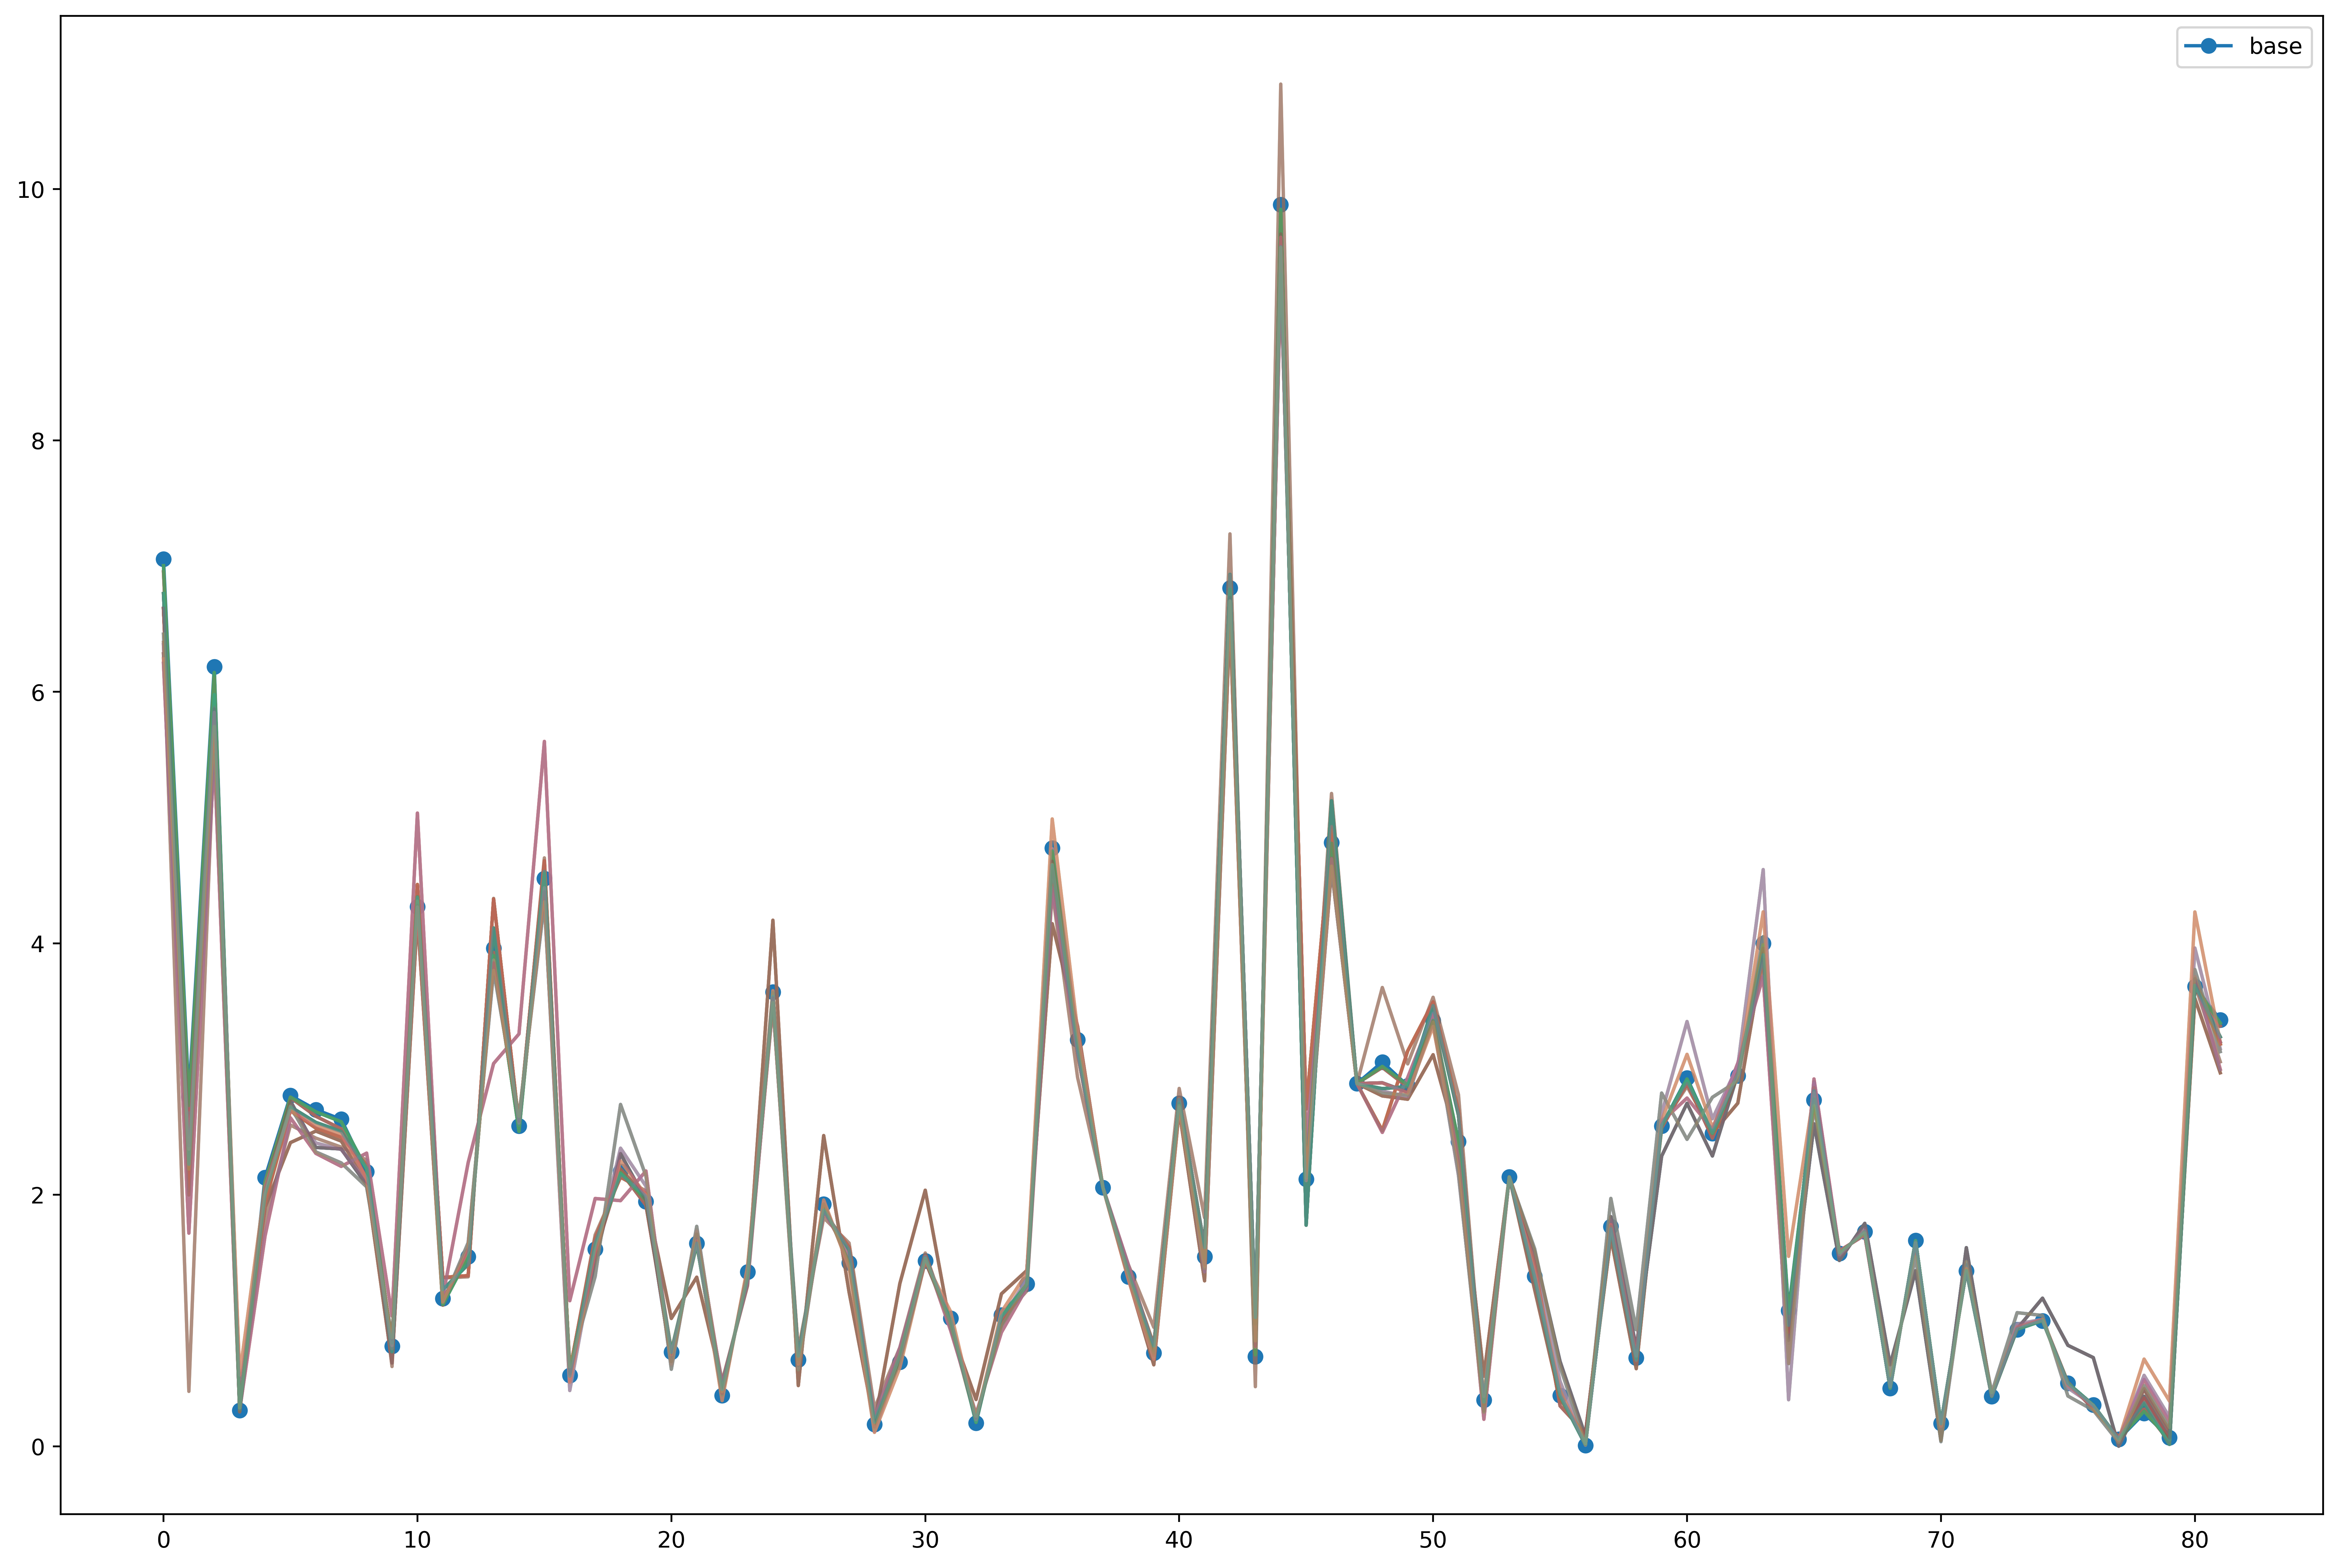

In [ ]:
plt.figure(figsize=(18,12),dpi=200)
pi = {}
pi2 = {}
net_base = pp.pandapowerNet(net3)
G_com,Net,G_power,target,G_power_nodes_Number = create_net(net_base)
bb1 = net_analysis2(G_power)
bb2 = net_analysis2(G_com)
num1 = 0.1
num2 = 0.3
tries = 100
gg1 = {}
gg2 = {}

# plt.plot(net['res_line']['loading_percent'],label=f'{name}',alpha=0.3)
for ids in range(tries):
    np.random.seed(0),np.random.rand(seed)
    net = pp.pandapowerNet(net3)
    if ids == 0:
        name = 'base'
        # print(net.gen['p_mw'].sum())
        pp.rundcpp(net)
        plt.plot(net['res_line']['loading_percent']
                 ,label=f'{name}',marker='o'
                ,alpha=1)
    elif ids > 0:
        # net ,name= gen_gy_simple(net,num1,num2,bb1,bb2,tries,ids)
        net ,name= gen_gy_simple(net,num1,num2,tries,ids)
        # name = 'not base'
        # print(net.gen['p_mw'].sum())
        pp.rundcpp(net)
        plt.plot(net['res_line']['loading_percent']
                #  ,label=f'{name}'
                ,alpha=0.3)

# # #         color='green', marker='o', linestyle='dashed',
# # # ...      linewidth=2, markersize=12
    # gg = {}
    # for kk in range(1,nodes):
    #     np.random.seed(0),np.random.rand(seed)
    #     net2 = pp.pandapowerNet(net)
    #     # print(net2.gen['p_mw'].sum())
    #     G_com,Net,G_power,target,G_power_nodes_Number = create_net(net2)
    #     # print(Net.gen['p_mw'].sum())
    #     G_com,Net,G_power = Remove_by_purpose(remove=kk)
    #     rm_nodes = set() - set()
    #     casecading = True
    #     while casecading:
    #         G_com = Largest_component_with_target(G_com,target)
    #         G_power = Largest_component_with_target(G_power,target)
    #         End_minus_One_of_casecade = (len(G_com.nodes()),len(G_power.nodes()))
    #         set_nodes = set(G_com.nodes() - G_power.nodes())
    #         if len(set_nodes)==0:
    #             set_nodes = set(G_power.nodes() - G_com.nodes())
    #         if len(set_nodes) != 0:
    #             # print("removed node/nodes in this time in casecading",set_nodes)
    #             Net = Casecade_in_pow(Net, set_nodes)
    #             G_power = top.create_nxgraph(Net)
    #             G_com = Casecade_in_com(G_com, set_nodes)
    #             # print("in line 127 ",self.G_com.nodes)
    #         End_of_casecade = (len(G_com.nodes()),len(G_power.nodes()))
    #         if End_minus_One_of_casecade == End_of_casecade:
    #             casecading = False
    #     # plt.plot(Net['res_line']['loading_percent'],label=f'{kk}',alpha=0.05)
    #     if name == 'base':
    #         gg1[f'{kk}'] = np.array(Net['res_line']['loading_percent'])
    #     else:
    #         gg2[f'{kk}'] = np.array(Net['res_line']['loading_percent'])

    # plt.label(f'{name}')
    # plt.legend()
    # plt.show()
            # print(self.casecading)
        # print(f'for removing {kk} with slacks {name}: ',1 - net2['bus'].shape[0]/nodes)
        # gg[f'{kk}-{bb1[kk]}-{bb2[kk]}'] = 1 - net2['bus'].shape[0]/nodes
        # gg[f'{kk}'] = 1 - net2['bus'].shape[0]/nodes

    # p = pd.DataFrame.from_dict(gg,orient='index')
    # pi[name] = list(np.array(p).reshape(-1,))
    # pi2[name] = np.sum(list(np.array(p).reshape(-1,)))
    # print(np.sum(list(np.array(p).reshape(-1,))))
    # plt.plot(p,label=f'{name}',alpha=0.3)
plt.legend()
plt.show()

In [ ]:
net3 = pn.case118()
# nodes = 300

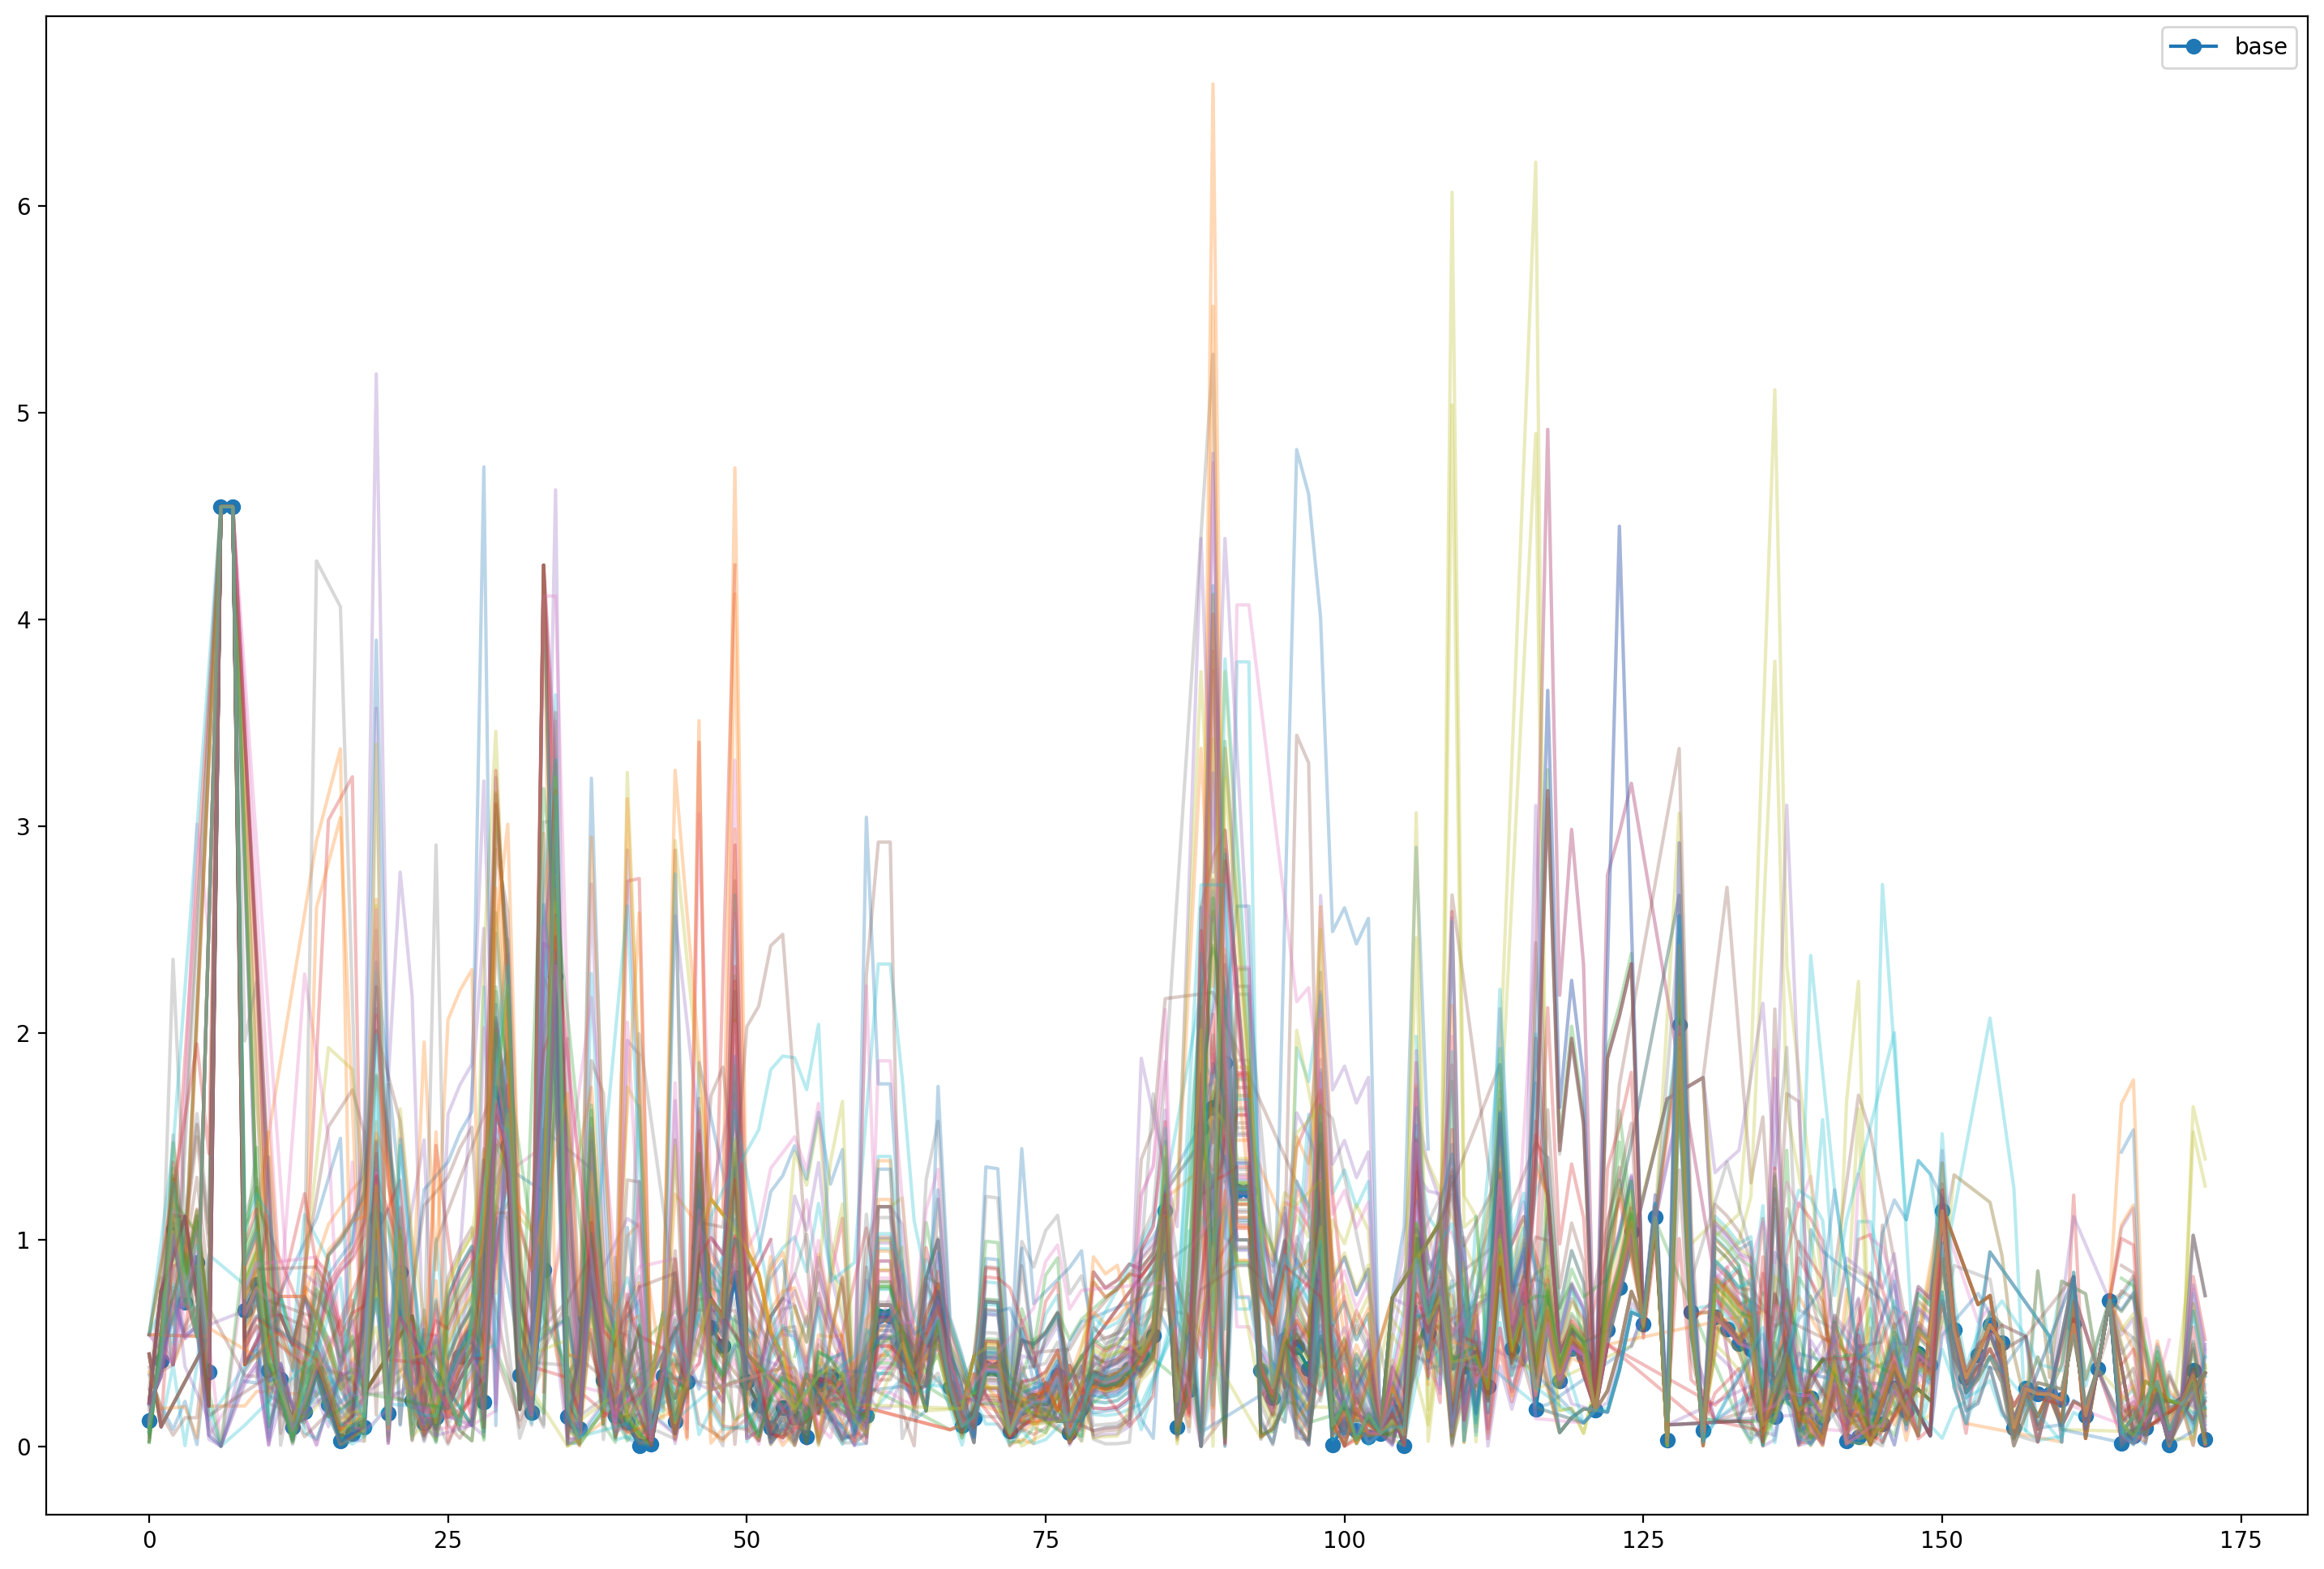

In [ ]:
plt.figure(figsize=(18,12),dpi=200)
pi = {}
pi2 = {}
net_base = pp.pandapowerNet(net3)
G_com,Net,G_power,target,G_power_nodes_Number = create_net(net_base)
bb1 = net_analysis2(G_power)
bb2 = net_analysis2(G_com)
num1 = 0.1
num2 = 0.3
tries = 100
gg1 = {}
gg2 = {}
# plt.plot(net['res_line']['loading_percent'],label=f'{name}',alpha=0.3)
for ids in range(tries):
    # np.random.seed(0),np.random.rand(seed)
    # rmv_nodes = np.random.randint(1,300,30)
    n = list(net['ext_grid']['bus'])[0]
    maxi = len(net3.bus)
    numi = int(maxi * 0.10)
    c = randis(maxi ,numi ,n)
    net = pp.pandapowerNet(net3)
    if ids == 0:
        name = 'base'
        # print(net.gen['p_mw'].sum())
        pp.rundcpp(net)
        plt.plot(net['res_line']['loading_percent']
                 ,label=f'{name}',marker='o'
                ,alpha=1)
    elif ids > 0:
        # net ,name= gen_gy_simple(net,num1,num2,bb1,bb2,tries,ids)
        # net ,name= gen_gy_simple(net,num1,num2,tries,ids)
        pp.drop_buses(net=net,buses=c,drop_elements=True)
        # name = 'not base'
        # print(net.gen['p_mw'].sum())
        pp.rundcpp(net)
        plt.plot(net['res_line']['loading_percent']
                #  ,label=f'{name}'
                ,alpha=0.3)
plt.legend()
plt.show()

In [369]:
nodes = 250
net3 = create_network1O1(nodes=nodes,k=4,p=0.25)

In [370]:
net3

This pandapower network includes the following parameter tables:
   - bus (250 element)
   - load (186 element)
   - gen (63 element)
   - ext_grid (1 elements)
   - line (399 element)
   - bus_geodata (250 element)
 and the following results tables:
   - res_bus (250 element)
   - res_line (399 element)
   - res_ext_grid (1 elements)
   - res_load (186 element)
   - res_gen (63 element)

In [371]:
list(net['ext_grid']['bus'])[0]

0

              name  bus  vm_pu  va_degree  slack_weight  in_service
0  Grid Connection    0   1.02        0.0           1.0        True
              name  bus  vm_pu  va_degree  slack_weight  in_service
0  Grid Connection    0   1.02        0.0           1.0        True
Empty DataFrame
Columns: [p_from_mw, q_from_mvar, p_to_mw, q_to_mvar, pl_mw, ql_mvar, i_from_ka, i_to_ka, i_ka, vm_from_pu, va_from_degree, vm_to_pu, va_to_degree, loading_percent]
Index: []
              name  bus  vm_pu  va_degree  slack_weight  in_service
0  Grid Connection    0   1.02        0.0           1.0        True
Empty DataFrame
Columns: [p_from_mw, q_from_mvar, p_to_mw, q_to_mvar, pl_mw, ql_mvar, i_from_ka, i_to_ka, i_ka, vm_from_pu, va_from_degree, vm_to_pu, va_to_degree, loading_percent]
Index: []
              name  bus  vm_pu  va_degree  slack_weight  in_service
0  Grid Connection    0   1.02        0.0           1.0        True
Empty DataFrame
Columns: [p_from_mw, q_from_mvar, p_to_mw, q_to_mvar, pl_m

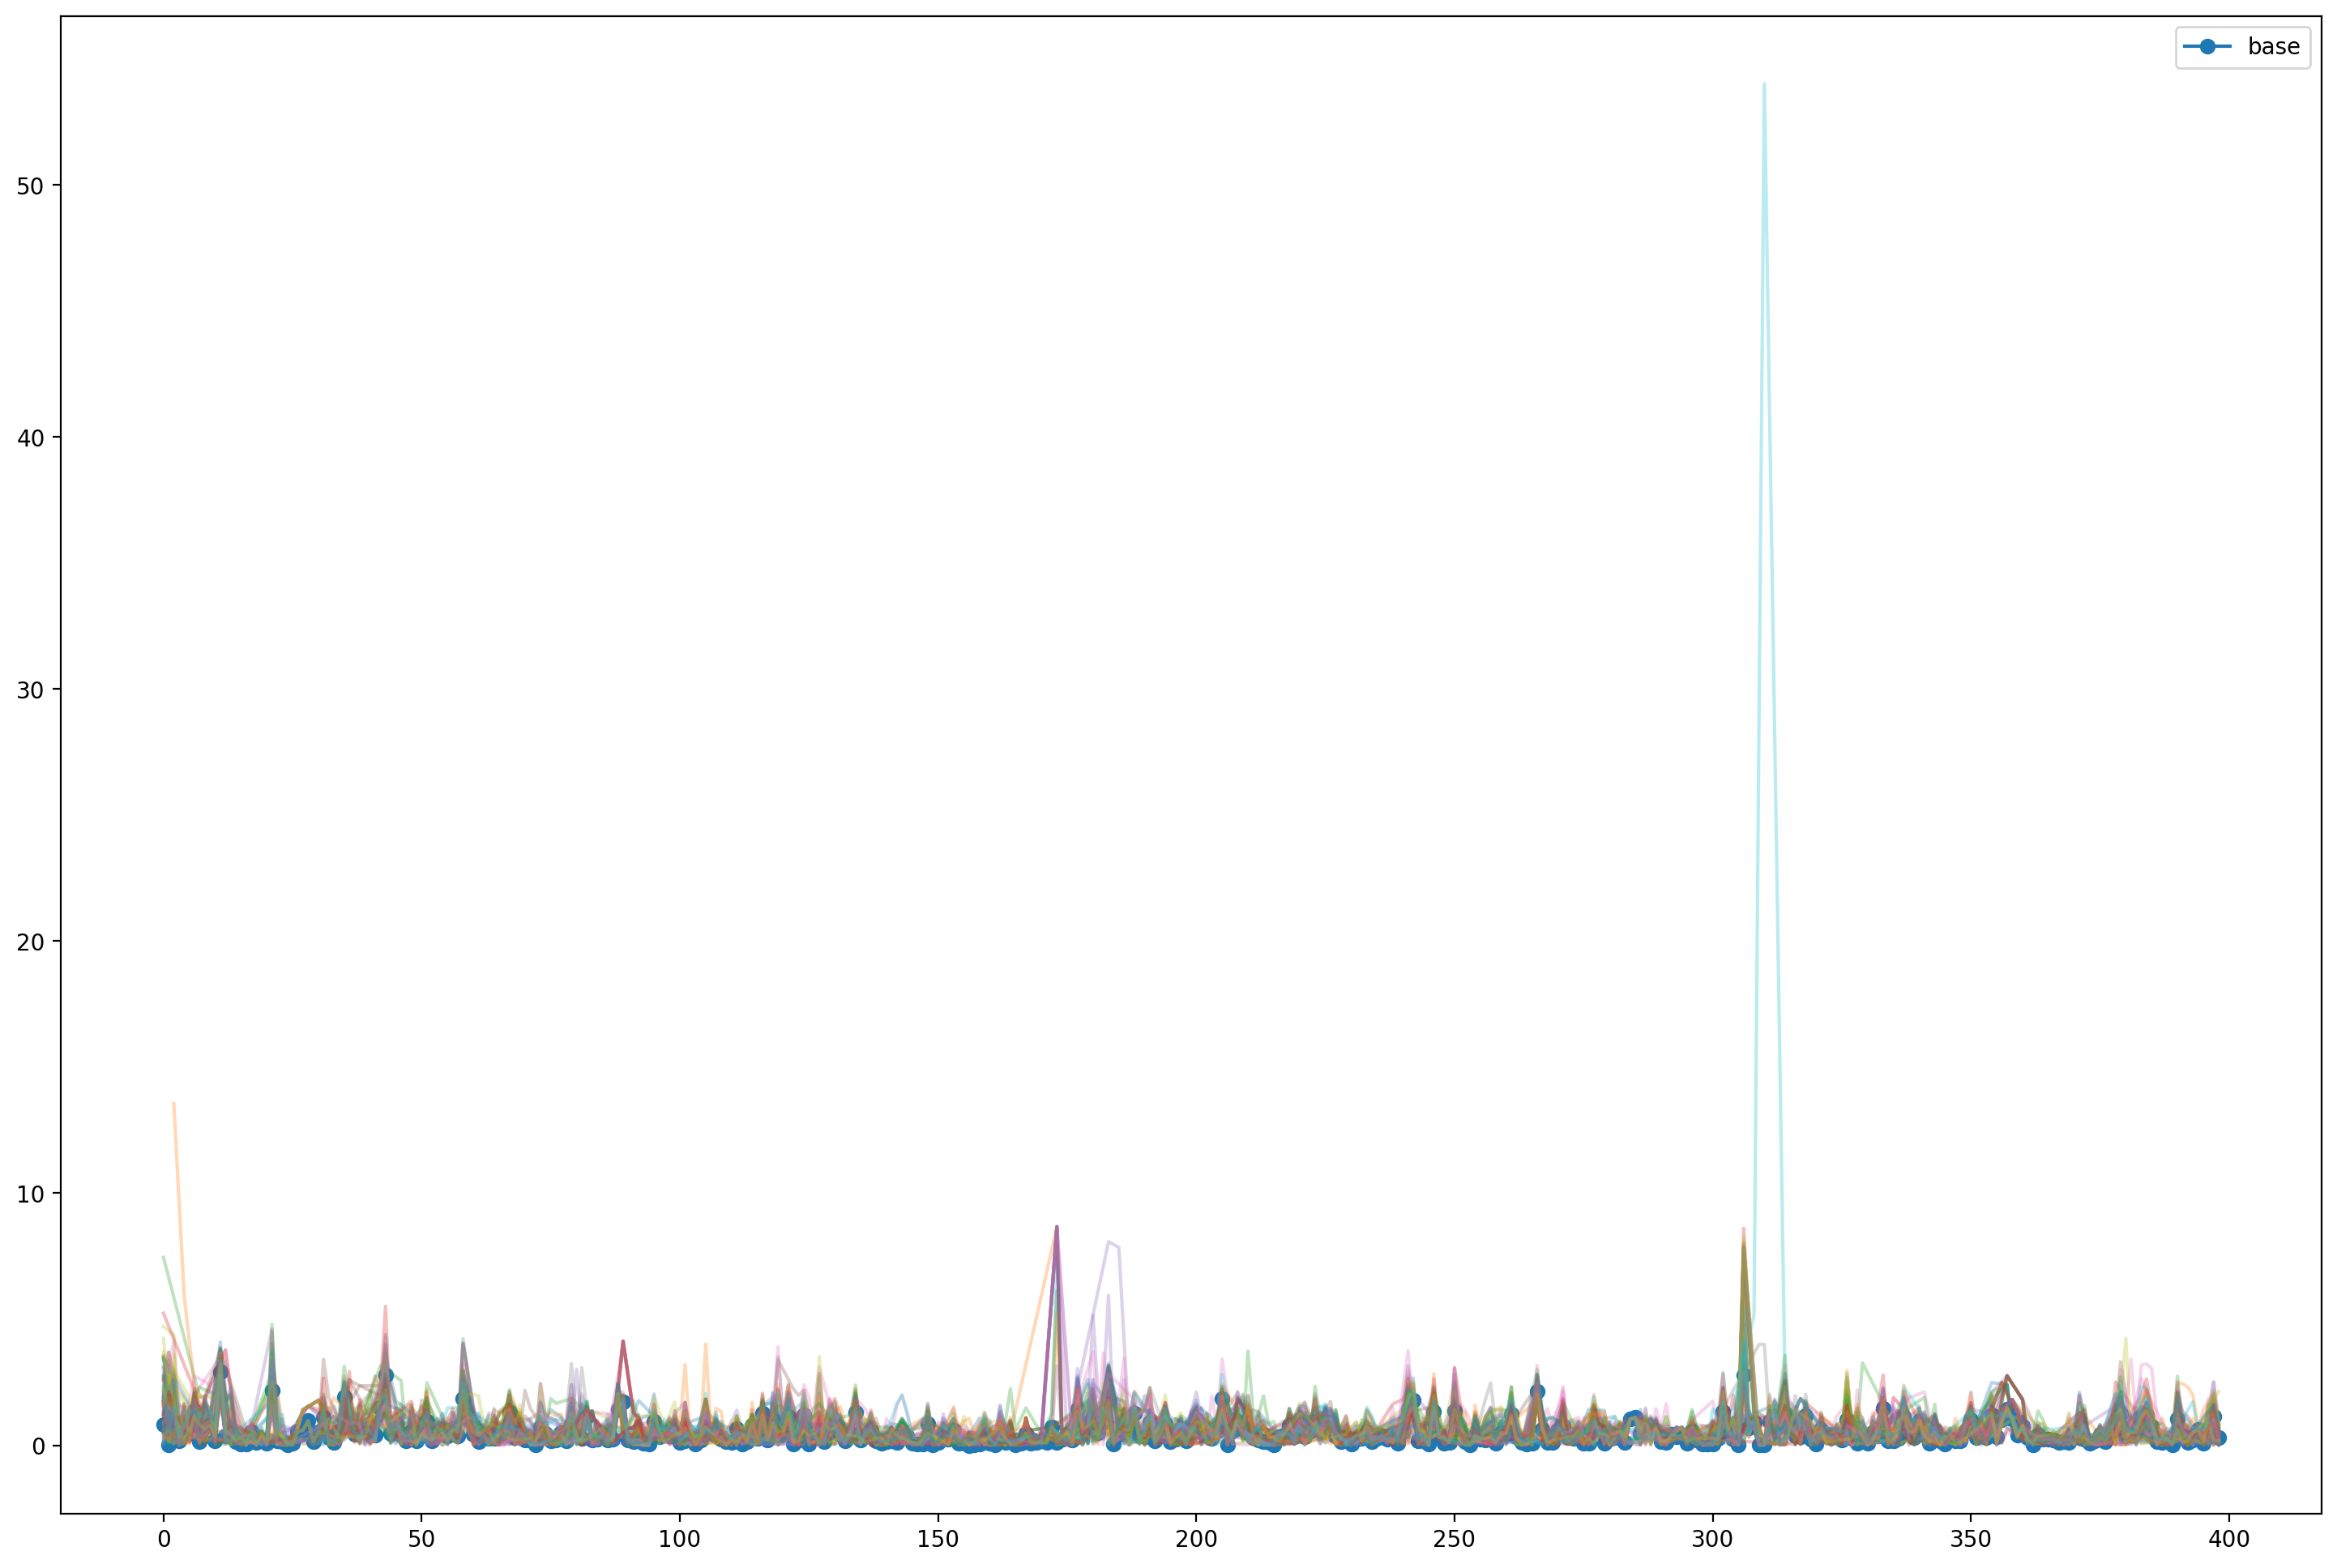

In [378]:
plt.figure(figsize=(18,12),dpi=200)
pi = {}
pi2 = {}
net_base = pp.pandapowerNet(net3)
G_com,Net,G_power,target,G_power_nodes_Number = create_net(net_base)
bb1 = net_analysis2(G_power)
bb2 = net_analysis2(G_com)
num1 = 0.1
num2 = 0.3
tries = 100
gg1 = {}
gg2 = {}
# plt.plot(net['res_line']['loading_percent'],label=f'{name}',alpha=0.3)
for ids in range(tries):
    # np.random.seed(0),np.random.rand(seed)
    # rmv_nodes = np.random.randint(1,300,30)
    print(net['ext_grid'])
    n = list(net['ext_grid']['bus'])[0]
    maxi = len(net3.bus)
    numi = int(maxi * 0.10)
    c = randis(maxi ,numi ,n)
    net = pp.pandapowerNet(net3)
    if ids == 0:
        name = 'base'
        # print(net.gen['p_mw'].sum())
        pp.rundcpp(net)
        plt.plot(net['res_line']['loading_percent']
                 ,label=f'{name}',marker='o'
                ,alpha=1)
    elif ids > 0:
        # net ,name= gen_gy_simple(net,num1,num2,bb1,bb2,tries,ids)
        # net ,name= gen_gy_simple(net,num1,num2,tries,ids)
        pp.drop_buses(net=net,buses=c,drop_elements=True)
        # name = 'not base'
        # print(net.gen['p_mw'].sum())
        pp.rundcpp(net)
        plt.plot(net['res_line']['loading_percent']
                #  ,label=f'{name}'
                ,alpha=0.3)
        # print(c)
        # print(net['res_line']['i_ka'].sum())
        print(net['res_line'][net['res_line']['loading_percent']>20])
plt.legend()
plt.show()

In [336]:
def randis(maxi ,numi ,n=0):
    c = np.random.randint(0,maxi,numi)
    try:
        r = True
        while r:
            c[np.where(c==n)[0][0]] = np.random.randint(0,maxi,1)
    except:pass
    return c

In [368]:
def create_network1O1(nodes=101,k=2,seed=seed,p=0.2,types=0):
    # np.random.seed(0)
    np.random.seed(seed)
    # np.random.rand(seed)


    if types == 1:
        G1 = nx.barabasi_albert_graph(nodes,m=k,seed=seed)
    elif types == 0:
        G1 = nx.watts_strogatz_graph(nodes,k,p=p,seed=seed)
    if k > 3:
        edges = G1.edges()
        # print('edges' , len(edges))
        m = np.array(edges)
        h = len(m[m[:,0]==0])
        # print('h',h)
        nds = G1.nodes()
        po = np.random.randint(int(h/2),len(edges),int(nodes*3.2))
        # print('po',len(po))
        eds = list(np.array(edges)[po])
        eds2 = list(np.array(edges)[0:int(h/2)])
        eds = eds + eds2
        eds = np.array(eds)
        # print('eds',len(eds))
        G=nx.empty_graph()
        G.add_nodes_from(nds)
        G.add_edges_from(np.array(eds))
        # print(len(G.edges()))
    else:
        G = G1
        # edges= G.edges()

    components_of_groph = sorted(nx.connected_components(G), key=len, reverse=True)
    while len(components_of_groph) != 1:
        multiple = len(components_of_groph)
        # print(f'model has {multiple} clusters so we connected them.')
        # drows2(G)
        # if len(components_of_groph)==2:
        g1 = list(components_of_groph[0])
        g2 = list(components_of_groph[1])
        if len(g2) < 3:
            k1 = 1
        else:
            k1 = k
        grand1 = np.random.randint(0,len(g1),k1)
        grand2 = np.random.randint(0,len(g2),k1)
        # print(grand1,grand2)
        for i,j in zip(grand1,grand2):
            print(g1[i],g2[j])
            G.add_edge(g1[i],g2[j])
        # else:pass
        components_of_groph = sorted(nx.connected_components(G), key=len, reverse=True)
    # drows2(G)


    Nett = pn.case118()

    #create empty net
    net = pp.create_empty_network()

    l =(nodes/Nett['bus'].shape[0]) # relation between our network on 118 network


    # sigma,mu  = Nett['load']['q_mvar'].std(),Nett['load']['q_mvar'].mean()
    # sigma,mu = sigma*l,mu*l
    # sigma,mu = sigma*l,mu
    sigma,mu = 0.2,0.5
    s2 = np.abs(np.random.normal(mu, sigma, nodes))
    s2[s2>0.8] = 0.8
    # s2[s2<0.1] = 0.8

    #create buses and bus elements
    sigma,mu  = Nett['bus']['vn_kv'].std(),Nett['bus']['vn_kv'].mean()
    # sigma,mu = sigma*l,mu*l
    sigma,mu = sigma,mu

    s0 = np.abs(np.random.normal(mu, sigma, nodes))

    sigma,mu  = Nett['load']['p_mw'].std(),Nett['load']['p_mw'].mean()
    s1 = np.abs(np.random.normal(mu, sigma, nodes))
    # sigma,mu = sigma*l,mu*l
    # sigma,mu = sigma*l,mu
    sigma,mu = sigma,mu

    nodes2 = nodes - int(30*l) - 1
    s1 = np.abs(np.random.normal(mu, sigma, nodes2))


    sigma,mu  = Nett['gen']['p_mw'].std(),Nett['gen']['p_mw'].mean()
    # sigma,mu = sigma*l,mu*l
    # sigma,mu = sigma*l,mu
    sigma,mu = sigma,mu


    s3 = np.abs(np.random.normal(mu, sigma,int(30*l)))

    check = s3.sum() - s1.sum()
    check_base = s3.sum() - s1.sum()
    lk1 = +1
    lk2 = -1
    while abs(check) > 40:
        s3 += s3*0.02 * lk1
        s1 += s1*0.02 * lk2
        check = s3.sum() - s1.sum()
        if abs(check) > abs(check_base):
            lk1 *= -1
            lk2 *= -1


    sigma,mu = 0.03,0.97
    s4 = np.abs(np.random.normal(mu, sigma, int(30*l)))

    for i in range(nodes):
        pp.create_bus(net, vn_kv=s0[i], name=f"Bus {i}")
        # if i not in jj:
            # pp.create_load(net, bus=i, p_mw=s1[i], q_mvar=s2[i], name=f"Load {i}")

    pp.create_ext_grid(net, bus=0, vm_pu=1.02, name="Grid Connection")

    jj = set()
    jj.add(0)
    for i in range(int(30*l)):
        g = True
        while g:
            j = np.random.randint(nodes)
            if j not in jj:
                pp.create_gen(net=net, bus=j, p_mw=s3[i], vm_pu=s4[i],name=f"gen {i}",max_p_mw=1.5*s3[i] ,min_p_mw=0,min_q_mvar=-20*l,max_q_mvar=20*l)
                jj.add(j)
                break
            else:pass
    s4 = np.abs(np.random.normal(mu, sigma, nodes))
    sigma,mu  = Nett['load']['p_mw'].std(),Nett['load']['p_mw'].mean()

    klo = 0
    for i in range(1,nodes):
        if i not in jj:
            # s1 = np.abs(np.random.normal(mu, sigma, nodes))
            # ko = np.abs(np.random.normal(mu, sigma))
            # print(ko)
            pp.create_load(net, bus=i, p_mw=s1[klo], q_mvar=s2[i]*s1[klo], name=f"Load {i}",vm_pu=s4[i])
            # print(s1[klo])

            klo += 1
    # print(klo,s1.shape)
    edges = list(G.edges())
    for i,j in edges:
        # print(i,j)
        pp.create_line(net, from_bus=i, to_bus=j, length_km=1, name=f"Line {i}-{j}",std_type="NAYY 4x50 SE",)

    # print(1)
    num_line = net['line'].shape[0]
    c1 = np.random.rand(num_line) * 2
    pp.rundcpp(net=net)
    # net['line']['max_i_ka'] = (net['res_line']['i_ka'].sort_values() / c1) * 100
    net['line']['max_i_ka'] *= net['res_line']['i_ka'].max() * 65
    # m1 = net['line']['max_i_ka'].mean()
    # m2 = net['line'][net['line']['max_i_ka'] > m1].index
    # print(m2)
    # net['line']['max_i_ka'][m2] *= 20
    # ss = net['res_line']['loading_percent']
    # ss = net['line']['max_i_ka'].sum()/net['res_line']['i_ka'].sum()
    # net['line']['max_i_ka'] *= np.log(net['res_line']['loading_percent'])**(6)
    # sd = [net['res_line']['i_ka'].max() for _ in range(len(net['res_line']['i_ka']))]
    # net['line']['max_i_ka'] = net['res_line']['i_ka'].max() * 2.5
    # print((net['res_line']['loading_percent'].max()/100))
    # net['line']['max_i_ka'] *= net['res_line']['i_ka']/net['res_line']['i_ka'].min()
    pp.rundcpp(net=net)

    # print(ss.max())
    m = np.array(net['res_line'][net['res_line']['loading_percent']>5].index)
    # print(net['line']['max_i_ka'][m])
    # net['line']['max_i_ka'][m] *= (net['res_line']['loading_percent'][m]*3)/100
    net['line']['max_i_ka'][m] *= 12

    # net['line']['max_i_ka'][m] *= (net['res_line']['loading_percent'][m]*(10 + np.random.rand() * 15))/100
    # pp.rundcpp(net=net)
    # print(net['line']['max_i_ka'][m])
    G_power = top.create_nxgraph(net=net)
    posP = nx.spring_layout(G_power, seed = seed)
    kl = pd.DataFrame().from_dict(posP,orient='index')
    net['bus_geodata']['x'] = kl[0]
    net['bus_geodata']['y'] = kl[1]
    net['bus_geodata']['coords'] = None
    ss1 = net['res_line']['loading_percent']



    return net

In [387]:
nodes = 250
net = create_network1O1(nodes=nodes,k=4,p=0.25)
# print(s3.sum() - s1.sum())
net.res_ext_grid


p_mw  q_mvar
0 -39.918702     NaN

In [353]:
3

3

In [354]:
# c1 = np.random.rand(net['line'].shape[0]) * 3

In [355]:
# c1.sort()
# c1 = c1[::-1]

In [356]:
# net['line'][net['line']['max_i_ka'] > net['line']['max_i_ka'].mean()]


In [357]:
# net['res_line']['i_ka']/net['res_line']['i_ka'].min()

In [358]:
# net['line']['max_i_ka']

In [359]:
# net['res_line']['i_ka'] / c1

In [360]:
# net['line']['max_i_ka'] = net['res_line']['i_ka'].sort_values() / c1

In [361]:
# i_ka = 1
# max_i_ka = 10
# loading_precent = i_ka / max_i_ka
# loading_precent

In [323]:
# i_ka = 1
# max_i_ka = 10
# loading_precent = i_ka / max_i_ka
# loading_precent

In [324]:
pp.rundcpp(net=net)

In [325]:
# 35000* 50000

<Axes: >

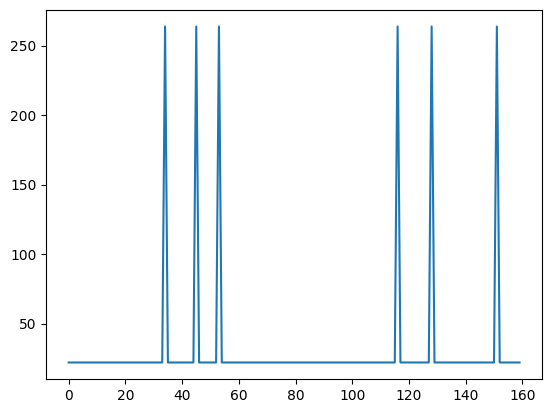

In [326]:
net['line']['max_i_ka'].plot()

<Axes: >

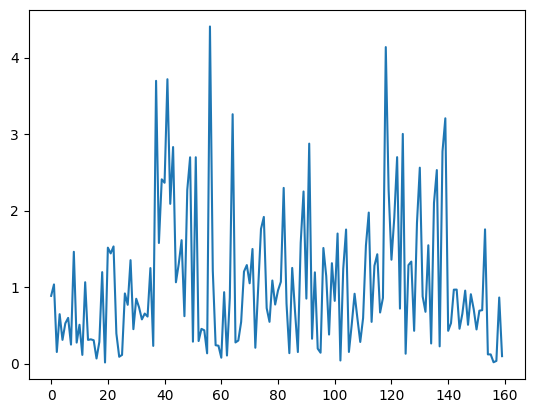

In [327]:
(net['res_line']['loading_percent']).plot()

In [388]:
m1 = net['res_line'][['p_from_mw','p_to_mw','i_ka','loading_percent']]

In [389]:
m2 = net['line'][['from_bus','to_bus','max_i_ka']]

In [390]:
m = pd.concat([m1,m2],axis=1)

In [391]:
# m.sort_values(by='loading_percent',ascending=False)
m

p_from_mw    p_to_mw      i_ka  loading_percent  from_bus  to_bus  \
0   -25.031508  25.031508  0.176952         0.827215         0       2   
1     1.013160  -1.013160  0.007162         0.033482         0     248   
2   -15.900354  15.900354  0.112402         0.525458         0       1   
3     8.117835  -8.117835  0.038243         0.178777         1       3   
4    27.377185 -27.377185  0.128201         0.599316         1     249   
5   -21.649879  21.649879  0.101381         0.473939         1       2   
6   -61.763340  61.763340  0.289223         1.352065         1      52   
7    -9.393063   9.393063  0.028036         0.131064         2     157   
8   -45.746875  45.746875  0.194542         0.909446         2       4   
9   -41.640861  41.640861  0.196168         0.917048         3       4   
10   -8.509231   8.509231  0.037466         0.175145         4       6   
11  -58.984331  58.984331  0.621864         2.907097         4       5   
12    7.329068  -7.329068  0.077269         0.361220         5       6   
13   10.425822 -10.425822  0.109918         0.513846         5      40   
14   -7.232777   7.232777  0.031846         0.148872         6     204   
15    2.017994  -2.017994  0.008885         0.041536         6      41   
16   -4.029963   4.029963  0.013947         0.065199         7     238   
17  -31.363312  31.363312  0.115910         0.541858         7       9   
18    6.631110  -6.631110  0.023044         0.107728         8      10   
19   15.609280 -15.609280  0.046683         0.218233         8      72   
20    3.963411  -3.963411  0.014648         0.068475         8       9   
21  -34.529967  34.529967  0.461687         2.158298         9     228   
22   -9.101267   9.101267  0.036511         0.170681         9      46   
23    8.340113  -8.340113  0.030823         0.144091         9      51   
24    1.554966  -1.554966  0.005747         0.026865         9      10   
25    4.078196  -4.078196  0.014173         0.066254        10     238   
26   38.420858 -38.420858  0.117340         0.548543        11      12   
27   28.163426 -28.163426  0.127370         0.595432        11      13   
28   35.134271 -35.134271  0.207887         0.971831        12      14   
29   -6.859891   6.859891  0.031024         0.145032        12      13   
30   19.150625 -19.150625  0.113313         0.529716        13      14   
31   40.416846 -40.416846  0.239143         1.117949        14      25   
32   10.661467 -10.661467  0.063083         0.294901        14      15   
33    3.146842  -3.146842  0.027463         0.128382        14      16   
34   47.359265 -47.359265  0.123497         0.577324        15      17   
35  -47.150951  47.150951  0.411487         1.923626        15      16   
36   20.214885 -20.214885  0.176416         0.824711        16     190   
37   10.651234 -10.651234  0.092954         0.434540        16      18   
38  -26.878891  26.878891  0.113047         0.528475        17      19   
39   33.329662 -33.329662  0.162533         0.759812        17      18   
40   31.095645 -31.095645  0.151639         0.708884        18      31   
41  -17.216197  17.216197  0.083955         0.392476        18      19   
42   76.049754 -76.049754  0.319850         1.495239        19      21   
43   54.674112 -54.674112  0.595980         2.786092        20     139   
44  -31.628695  31.628695  0.097960         0.457945        20      22   
45  -45.849064  45.849064  0.184479         0.862407        20      21   
46   21.957698 -21.957698  0.088693         0.414621        21      23   
47    8.679793  -8.679793  0.034924         0.163264        21      22   
48  -24.420870  24.420870  0.119657         0.559372        22     195   
49    8.506595  -8.506595  0.038386         0.179445        23     107   
50  -33.956997  33.956997  0.137161         0.641201        23      25   
51   35.381761 -35.381761  0.200062         0.935254        23     243   
52   -6.188052   6.188052  0.037233         0.174058        24      25   
53  -17.8

In [393]:
net['res_bus'][177:181]

vm_pu  va_degree       p_mw  q_mvar
177  0.93134   0.021187 -75.180957     NaN
178  1.00000   0.017844  16.792816     NaN
179  1.00000   0.014775  14.373685     NaN
180  1.00000   0.009228   2.326045     NaN

# !

In [158]:
net = pn.case118()
pp.rundcpp(net=net)

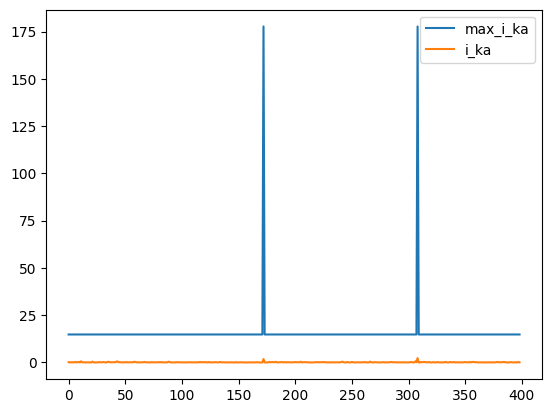

In [367]:
ax = net['line']['max_i_ka'].plot()
net['res_line']['i_ka'].plot(ax=ax)
plt.legend()


In [109]:
net['res_line']['i_ka'].sum()

537.5574445959223

In [113]:
net['res_line']['i_ka']

0       1.887844e-01
1       5.362943e-02
2       3.038686e-01
3       3.909042e-01
4       1.256724e-01
5       2.127080e-01
6       2.540567e-01
7       2.315579e-02
8       2.309009e-01
9       5.132002e-03
10      2.950901e-02
11      2.458472e-03
12      2.810847e-01
13      2.909301e-01
14      5.625159e-02
15      6.246205e-02
16      9.383539e-04
17      2.411468e-01
18      6.779433e-02
19      2.788793e-01
20      1.180330e-01
21      1.999759e-01
22      3.151049e-02
23      5.067852e-02
24      1.154102e-01
25      9.219372e-02
26      4.764207e-02
27      4.366056e-01
28      2.600117e-01
29      8.765089e-02
30      4.362245e-01
31      2.665613e-01
32      3.566742e-02
33      3.566742e-02
34      3.757359e-02
35      2.430767e-02
36      5.817094e-02
37      1.514824e-01
38      1.564377e-01
39      8.981004e-02
40      2.857126e-01
41      4.011827e-01
42      1.099715e-01
43      2.452013e-01
44      4.684945e-02
45      3.242885e-02
46      1.066916e-02
47      8.797

In [57]:
# net['res_line']['i_ka']

In [58]:
net['res_line']['i_ka'].sum()

29.573144270607408

In [59]:
net['line']['max_i_ka'].sum()/net['res_line']['i_ka'].sum()

235.57216339669043

In [60]:
# net['res_line']['i_ka']

In [61]:
0.078903 / 11

0.007173

In [62]:
net['line']

name std_type  from_bus  to_bus  length_km  r_ohm_per_km  x_ohm_per_km  \
0    None     None         0       1        1.0      5.770332     19.024956   
1    None     None         0       2        1.0      2.456676      8.074656   
2    None     None         3       4        1.0      0.335174      1.519711   
3    None     None         2       4        1.0      4.589604     20.567520   
4    None     None         4       5        1.0      2.266236     10.283760   
5    None     None         5       6        1.0      0.874120      3.961152   
6    None     None         7       8        1.0      2.904210     36.302625   
7    None     None         8       9        1.0      3.070845     38.326050   
8    None     None         3      10        1.0      3.980196     13.102272   
9    None     None         4      10        1.0      3.865932     12.988008   
10   None     None        10      11        1.0      1.133118      3.732624   
11   None     None         1      11        1.0      3.561228     11.731104   
12   None     None         2      11        1.0      9.217296     30.470400   
13   None     None         6      11        1.0      1.641593      6.474960   
14   None     None        10      12        1.0      4.237290     13.921164   
15   None     None        11      13        1.0      4.094460     13.464108   
16   None     None        12      14        1.0     14.168736     46.543536   
17   None     None        13      14        1.0     11.331180     37.135800   
18   None     None        11      15        1.0      4.037328     15.882696   
19   None     None        14      16        1.0      2.513808      8.322228   
20   None     None        15      16        1.0      8.645976     34.298244   
21   None     None        16      17        1.0      2.342412      9.617220   
22   None     None        17      18        1.0      2.131024      9.388692   
23   None     None        18      19        1.0      4.799088     22.281480   
24   None     None        14      18        1.0      2.285280      7.503336   
25   None     None        19      20        1.0      3.485052     16.168356   
26   None     None        20      21        1.0      3.980196     18.472680   
27   None     None        21      22        1.0      6.513048     30.279960   
28   None     None        22      23        1.0      2.570940      9.369648   
29   None     None        22      24        1.0      2.970864     15.235200   
30   None     None        24      26        1.0      6.055992     31.041720   
31   None     None        26      27        1.0      3.643117     16.282620   
32   None     None        27      28        1.0      4.513428     17.958492   
33   None     None         7      29        1.0      5.129977     59.988600   
34   None     None        25      29        1.0      9.510098    102.361500   
35   None     None        16      30        1.0      9.026856     29.765772   
36   None     None        28      30        1.0      2.056752      6.303564   
37   None     None        22      31        1.0      6.036948     21.957732   
38   None     None        30      31        1.0      5.675112     18.758340   
39   None     None        26      31        1.0      4.361076     14.378220   
40   None     None        14      32        1.0      7.236720     23.690736   
41   None     None        18      33        1.0     14.321088     47.038680   
42   None     None        34      35        1.0      0.426586      1.942488   
43   None     None        34      36        1.0      2.094840      9.464868   
44   None     None        32      36        1.0      7.903260     27.042480   
45   None     None        33      35        1.0      1.658732      5.103792   
46   None     None        33      36        1.0      0.487526      1.790136   
47   None     None        36      38        1.0      6.113124     20.186640   
48   None     None        36      39        1.0     11.293092     31.993920   
49   None     None        29      37        1.0      5.

In [63]:
net['res_line']

p_from_mw  q_from_mvar     p_to_mw  q_to_mvar  pl_mw  ql_mvar  \
0    -11.766082          0.0   11.766082        0.0    0.0      0.0   
1    -39.233918          0.0   39.233918        0.0    0.0      0.0   
2   -103.794382          0.0  103.794382        0.0    0.0      0.0   
3    -69.054517          0.0   69.054517        0.0    0.0      0.0   
4     87.176321          0.0  -87.176321        0.0    0.0      0.0   
5     35.176321          0.0  -35.176321        0.0    0.0      0.0   
6   -450.000000          0.0  450.000000        0.0    0.0      0.0   
7   -450.000000          0.0  450.000000        0.0    0.0      0.0   
8     64.794382          0.0  -64.794382        0.0    0.0      0.0   
9     77.509276          0.0  -77.509276        0.0    0.0      0.0   
10    35.869951          0.0  -35.869951        0.0    0.0      0.0   
11   -31.766082          0.0   31.766082        0.0    0.0      0.0   
12    -9.179401          0.0    9.179401        0.0    0.0      0.0   
13    16.176321          0.0  -16.176321        0.0    0.0      0.0   
14    36.433706          0.0  -36.433706        0.0    0.0      0.0   
15    19.891045          0.0  -19.891045        0.0    0.0      0.0   
16     2.433706          0.0   -2.433706        0.0    0.0      0.0   
17     5.891045          0.0   -5.891045        0.0    0.0      0.0   
18     9.209744          0.0   -9.209744        0.0    0.0      0.0   
19  -105.967580          0.0  105.967580        0.0    0.0      0.0   
20   -15.790256          0.0   15.790256        0.0    0.0      0.0   
21    81.248845          0.0  -81.248845        0.0    0.0      0.0   
22    21.248845          0.0  -21.248845        0.0    0.0      0.0   
23   -10.753397          0.0   10.753397        0.0    0.0      0.0   
24    13.194200          0.0  -13.194200        0.0    0.0      0.0   
25   -28.753397          0.0   28.753397        0.0    0.0      0.0   
26   -42.753397          0.0   42.753397        0.0    0.0      0.0   
27   -52.753397          0.0   52.753397        0.0    0.0      0.0   
28    21.157633          0.0  -21.157633        0.0    0.0      0.0   
29  -169.474120          0.0  169.474120        0.0    0.0      0.0   
30   139.347312          0.0 -139.347312        0.0    0.0      0.0   
31    32.948397          0.0  -32.948397        0.0    0.0      0.0   
32    15.948397          0.0  -15.948397        0.0    0.0      0.0   
33    84.465505          0.0  -84.465505        0.0    0.0      0.0   
34   225.178568          0.0 -225.178568        0.0    0.0      0.0   
35    13.606206          0.0  -13.606206        0.0    0.0      0.0   
36    -8.051603          0.0    8.051603        0.0    0.0      0.0   
37    88.563091          0.0  -88.563091        0.0    0.0      0.0   
38   -30.445396          0.0   30.445396        0.0    0.0      0.0   
39    13.982016          0.0  -13.982016        0.0    0.0      0.0   
40    11.098131          0.0  -11.098131        0.0    0.0      0.0   
41     0.196442          0.0   -0.196442        0.0    0.0      0.0   
42     0.790433          0.0   -0.790433        0.0    0.0      0.0   
43   -33.790433          0.0   33.790433        0.0    0.0      0.0   
44   -11.901869          0.0   11.901869        0.0    0.0      0.0   
45    30.209567          0.0  -30.209567        0.0    0.0      0.0   
46   -93.386229          0.0   93.386229        0.0    0.0      0.0   
47    56.861358          0.0  -56.861358        0.0    0.0      0.0   
48    46.630453          0.0  -46.630453        0.0    0.0      0.0   
49    80.547794          0.0  -80.547794        0.0    0.0      0.0   
50    29.861358          0.0  -29.861358        0.0    0.0      0.0   
51    18.857380          0.0  -18.857380        0.0    0.0      0.0   
52    -8.365569          0.0    8.365569        0.0    0.0      0.0   
53   -18.142620          0.0   18.142620        0.0    0.0      0.0   
54   -13.626896          0.0   13.626896        0.0    0.0      0.0   
55     4.373104          0.0  

In [ ]:
net['res_line']['i_ka'] / net['res_line']['loading_percent']

0     0.100000
1     0.100000
2     0.100000
3     0.100000
4     0.100000
5     0.100000
6     0.100000
7     0.100000
8     0.100000
9     0.100000
10    0.100000
11    0.100000
12    0.100000
13    0.100000
14    0.100000
15    0.100000
16    0.100000
17    0.100000
18    0.100000
19    0.100000
20    0.100000
21    0.100000
22    0.100000
23    0.100000
24    0.100000
25    0.100000
26    0.100000
27    0.293054
28    0.100000
29    0.100000
30    0.100000
31    0.100000
32    0.100000
33    0.100000
34    0.285513
35    0.100000
36    0.100000
37    0.100000
38    0.100000
39    0.100000
40    0.100000
41    0.100000
42    0.100000
43    0.100000
44    0.100000
45    0.100000
46    0.100000
47    0.100000
dtype: float64

In [ ]:
s1.sum(),s3.sum()

(10687.744822549112, 10197.187640565666)

In [ ]:
# s3

In [ ]:
# net['gen']['p_mw']

In [ ]:
net['gen']['p_mw'].sum()

23479.43

In [ ]:
net['load']['p_mw'].sum()

23847.65

In [ ]:
nodes = 118
net = create_network1O1(nodes=nodes,k=4,p=0.25)

1177.3802446832842
2010133.264829492


In [ ]:
1.5/3836

0.0003910323253388947

In [ ]:
np.log(net['res_line']['loading_percent'])**4

0       93.339078
1      543.132875
2      504.216286
3      125.120600
4      383.958039
5      222.526915
6     1474.357863
7       16.304188
8     1911.205571
9      393.913093
10     550.786142
11    4081.365753
12     507.784742
13       6.012228
14     240.030079
15     207.795126
16     453.091956
17     270.637483
18     847.264062
19    1317.736776
20     401.538785
21     633.760782
22     211.283476
23     571.575843
24     563.638773
25     468.961870
26     333.998085
27     330.157064
28     546.904129
29     671.385742
30    1046.082759
31    1020.154225
32     100.672119
33     905.051766
34    1036.279533
35    1048.552174
36     986.677190
37    1059.776373
38     105.355810
39     752.902987
40     838.508521
41      98.987998
42     418.403468
43     690.882116
44    1358.877251
45     783.488827
46     605.002974
47     121.786853
48     978.628804
49    1402.047120
50    1259.459019
51     511.287497
52    2193.920269
53     997.099223
54     739.399384
55      21

<Axes: >

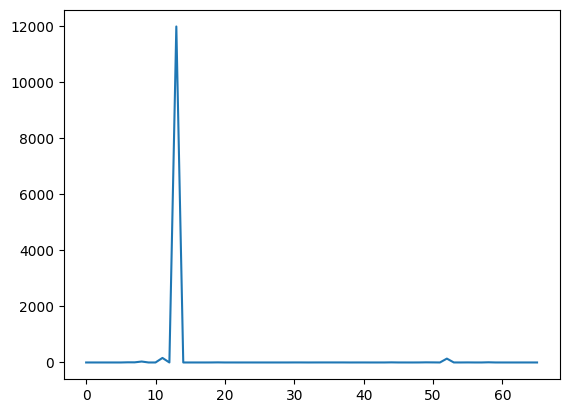

In [ ]:
(net['res_line']['loading_percent']/np.log(net['res_line']['loading_percent'])**4).plot()

<Axes: >

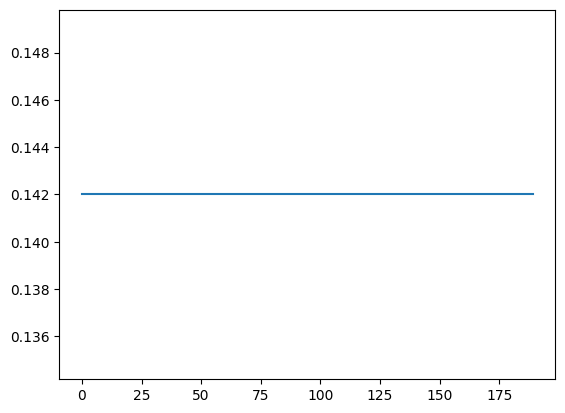

In [ ]:
net['line']['max_i_ka'].plot()

<Axes: >

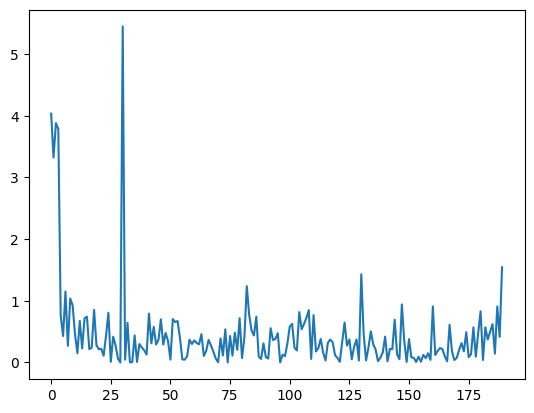

In [ ]:
net['res_line']['i_ka'].plot()

<Axes: >

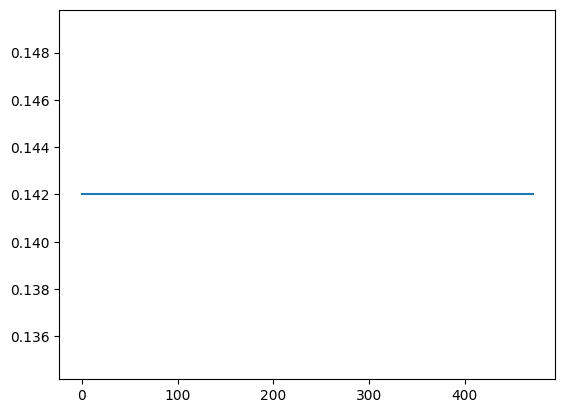

In [ ]:
net['line']['max_i_ka'].plot()

In [ ]:
s1.max()

143.83469984451176

In [ ]:
s3.max()

428.4686077882585

In [ ]:
net['gen']['p_mw'].sum()

3766.331685560675

In [ ]:
net['load']['p_mw'].sum()

4357.515364325675

In [ ]:
pp.rundcpp(net=net)

<Axes: >

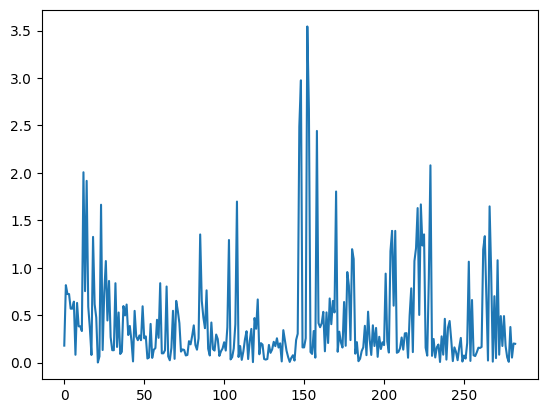

In [ ]:
net['res_line']['i_ka'].plot()

In [ ]:
ss1

0      4.130172
1      4.130172
2      4.130172
3      4.130172
4      4.130172
5      4.130172
6      4.130172
7      4.130172
8      4.130172
9      4.130172
10     4.130172
11     4.130172
12     4.130172
13     4.130172
14     4.130172
15     4.130172
16     3.105064
17     4.130172
18     4.130172
19     4.130172
20     7.744790
21     4.130172
22     4.130172
23     4.130172
24     4.130172
25     4.130172
26     4.130172
27     4.126551
28     4.130172
29     4.130172
30     3.572046
31     4.130172
32     4.130172
33     4.130172
34     4.130172
35     4.130172
36     4.130172
37     4.130172
38     4.130172
39     4.130172
40     4.130172
41     4.130172
42     4.130172
43     4.130172
44     4.130172
45     4.800044
46     4.130172
47     4.130172
48     4.130172
49     4.130172
50     4.130172
51     4.130172
52     4.130172
53     4.130172
54     4.130172
55     4.130172
56     4.130172
57     4.130172
58     4.130172
59     4.130172
60     4.130172
61     4.130172
62     4